# Creación de los modelos neuronales para la regresión.

Se proponen varios modelos neuronales para realizar la regresión predictiva de la serie temporal de temperaturas y humedades:
- Red recurrente _GRU_.
- Red recurrente _LSTM_.
- Perceptrón multicapa (únicamente como caso de estudio particular de modelos no secuenciales "feed-forward").

En este Python Notebook se abordará la tarea de la transformación de los datos para el entrenamiento de los diferentes modelos, así como
la configuración de los hiperparámetros relacionados para ajustar el aprendizaje y poder obtener unos resultados adecuados.

Además, se realizarán las visualizaciones de los resultados mediante gráficas de dispersión de las predicciones y los valores reales,
así como la distribución del error en el conjunto de test y el error máximo obtenido.

Realizamos las importaciones de las librerías de terceros, las utilidades nativas de Python y los módulos desarrollados

In [30]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from env_paths import *
from global_variables import *

Se crean las funciones que se emplearán durante los entrenamientos de los modelos.

Entre ellas encontramos:
- Función de normalización: emplea la normalización de máximos y mínimos para establecer el rango de los atributos de 0-1.
- Función de denormalización: premite denormalizar los atributos del conjunto.
- Función max_error: calcula el error máximo y obtiene la gráfica con la distribución temporal de los errores de predicción 
en el conjunto de test.
- Función get_predictions: función que permite obtener las predicciones (single-step o multi-step según sea) de un modelo determinado
por parámetro.
- Función plot_results: función que permite graficar los resultados en una gráfica de dispersión por sensor y atributo, para, de esta forma,
hacer más visual las predicciones obtenidas.

In [31]:
def denormalize(predictions):
    for col in OUTPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (maximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

def max_error(targets, predictions):
    for col in OUTPUT_COLS:
        max_value = 0
        errors = []
        for target, prediction in zip(targets, predictions):
            max_value = max(max_value, max(abs(target[col] - prediction[col])))
            errors.append(target[col] - prediction[col])
        plt.figure()
        plt.suptitle(col)
        plt.plot(errors)
        plt.xlabel("Error máximo: " + str(max_value))
        plt.show()

def get_predictions(model, X_test):
    predictions = []
    for prediction_window in model.predict(X_test):
        prediction = pd.DataFrame(data=prediction_window, columns=OUTPUT_COLS)
        prediction = denormalize(prediction)
        predictions.append(prediction)
    return predictions

def plot_results(targets, predictions, data_limits):
    for sensor, (lim_inf, lim_sup) in enumerate(zip(data_limits, data_limits[1:]), 1):
        fig, axs = plt.subplots(2, 3, figsize=(16, 9))

        for i, col in enumerate(OUTPUT_COLS):
            target_stream = np.array([])
            prediction_stream = np.array([])
            
            for target, prediction in zip(targets[lim_inf:lim_sup], predictions[lim_inf:lim_sup]):
                target_stream = np.concatenate([target_stream, target[col].to_numpy()])
                prediction_stream = np.concatenate([prediction_stream, prediction[col].to_numpy()])
            
            
            fig.suptitle("Sensor " + str(sensor))
            axs[i % 2, i % 3].scatter(range(len(target_stream)), target_stream, linewidths=0.5, s=0.5)
            axs[i % 2, i % 3].scatter(range(len(prediction_stream)), prediction_stream, linewidths=0.5, s=0.5)
            axs[i % 2, i % 3].legend(["Valor real", "Prediccion"])
            axs[i % 2, i % 3].set_xlabel(col)
        plt.show()

def history_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.plot(hist['epoch'], hist['loss'], label='Train error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error")
    plt.legend()

    plt.legend()

De esta manera, se han parametrizado ciertos aspectos de la creación de los modelos, incluyendo:
- Learning rate: ratio de aprendizaje de los modelos, aplicados en el cálculo de los pesos sinápticos.
- Tamaño de lote (batch size): cantidad de datos que se introducen en bloque durante una iteración del entrenamiento.
- Epochs: número de épocas de entrenamiento.
- Tamaño de la ventana de entrada: Número de datos previos (se corresponden con horas) para realizar las predicciones.
- Tanaño de la ventana de salida: Número de ejemplos en cada predicción.
- Fracción de entrenamiento: Porcentaje del conjunto de datos de cada sensor que se va a emplear en el entrenamiento.
- Fracción de validación: Porcentaje del conjunto de datos de cada sensor que se va a emplear en la validación, quedando el restante para 
test.

Se permite también cambiar el optimizador empleado para la minimización del error cuadrático medio (MSE) empleado en los modelos, así
como variar el esquema para variar el ratio de aprendizaje en el tiempo (épocas de entrenamiento).

La función get_scheduler, servirá, de esta forma, para instanciar un nuevo esquema del ratio de aprendizaje para cada modelo 


In [32]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 256 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA
window_size_inputs = 6 # Tamanno de la ventana de datos previos para predecir los posteriores
window_size_targets = 1 # Tamanno de la ventana de datos posteriores (datos a predecir)
train_frac = 0.75 # Fraccion de datos de entrenamiento
val_frac = 0.15 # Fraccion de datos de validacion, el porcentaje restante se dedica a test

def get_optimizer():
    return kr.optimizers.Adam(learning_rate=learning_rate)

def scheduler(epoch, lr):
    return lr if epoch < 50 else lr * tf.math.exp(-0.1) 

def get_scheduler():
    return kr.callbacks.LearningRateScheduler(scheduler)

# Carga del conjunto de datos

Mediante Pandas se carga el conjunto de datos integrado en el Python Notebook "data-integration.ipynb".

Se convierte el _timestamp_ en un DateTime para posteriormente poder crear grupos que permitan clasificar los datos
por instantes de tiempo.

Se muestra la cantidad presente en el conjunto de datos, así como los atributos de los que cuenta.

In [33]:
# files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(INTEGRATED_DATA_PATH)
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)
df.shape

(60489, 8)

Como los datos debido al proceso de limpieza y selección cuentan con saltos temporales será necesario recorrer por cada uno de los sensores
el conjunto correspondiente comprobando dónde se producen estas situaciones.

Una vez que se tienen los subconjuntos de datos separadas que no cuentan con saltos temporales es necesario establecer una ventana deslizante para 
comenzar con el proceso de transformación de los datos, de forma que se comprueba que cuente con un número de ejemplos equivalente a suma de entrada y salida indicada en los parámetros,
y en caso afirmativo introducirlos al conjunto de datos de entrada y salida respectivamente

In [34]:
X_train, y_train = np.array([]), np.array([]) # Cjto de entrenamiento
X_val, y_val = np.array([]), np.array([]) # Cjto de validacion
X_test, y_test = np.array([]), np.array([]) # Cjto de test

data_limits = [0] # Almacena el tamanno de los datos de los sensores para poder graficarlos posteriormente 

sensor_group = df.groupby('sensor')
for _,sensor in sensor_group:
    X = [] # Inputs
    y = [] # Targets
    
    rolling_win = sensor.groupby(pd.Grouper(freq="1H", key="ts"))
    data_windows = [] # Ventana de datos para evitar los saltos temporales
    data_window = []

    # Separamos cada ventana de datos para poder crear el conjunto de datos de entrenamiento
    for _, group in rolling_win: 
        if len(group) == 0 and len(data_window) > 0:
            data_windows.append(data_window)
            data_window = []
        if len(group) > 0:
            data_window.append(group[INPUT_COLS].to_numpy()[0])
    data_windows.append(data_window)


    for data_window in data_windows:
        # En cada ventana de datos comprobamos si hay datos suficientes para la prediccion 
        # temporal, sino continuamos con la siguiente ventana
        if(len(data_window) < window_size_inputs + window_size_targets):
            continue
        # Por cada ventana la recorremos creando una subventana deslizante obteniendo 
        # los inputs de la RNA y el target correspondiente.
        for i in range(len(data_window) - (window_size_inputs + window_size_targets)):
            X.append([a for a in data_window[i : i + window_size_inputs]])
            # Se selecciona para el conjunto de targets todas las columnas menos la del numero de sensor.
            y.append([a[:-1] for a in data_window[i + window_size_inputs : i + window_size_inputs + window_size_targets]])
    
    X = np.array(X)
    y = np.array(y)

    # Dividimos el conjunto de datos de cada sensor en entrenamiento, validacion y test.
    train_lim = int(len(X) * train_frac)
    val_lim = train_lim + int(len(X) * val_frac)
    
    # Si el tamanno del conjunto de entrenamiento es 0 es porque todavia no hay datos
    if len(X_train) == 0:
        X_train, y_train = X[:train_lim], y[:train_lim]
        X_val, y_val = X[train_lim : val_lim], y[train_lim : val_lim]
        X_test, y_test = X[val_lim:], y[val_lim:]
        continue

    X_train, y_train = np.concatenate((X_train, X[:train_lim])), np.concatenate((y_train, y[:train_lim]))
    X_val, y_val = np.concatenate((X_val, X[train_lim : val_lim])), np.concatenate((y_val, y[train_lim : val_lim]))

    data_limits.append(len(y_test))

    X_test, y_test = np.concatenate((X_test, X[val_lim:])), np.concatenate((y_test, y[val_lim:]))
data_limits.append(len(y_test))


Una vez se hayan transformado los datos en los diferentes conjuntos puede comenzarse el proceso del entrenamiento de los diferentes modelos.

Como se ha mencionado, se crearán diferentes modelos (_GRU_, _LSTM_ y _MLP_).

# GRU

En _GRU_ se debe indicar el tamaño del tensor de entrada y el tensor de salida de la regresión.
En las capas intermedias debe retornarse las secuencias completas, de forma que será en la última capa donde se 
obtendrá el resultado final.

En cuanto al tamaño de las unidades de la clase "_GRU_" hacen referencia al número de celdas de memoria presentes en cada 
capa. Por otro lado, se emplearán las funciones de activación por defecto de las diferentes compuertas de las celdas (funcion sigmoidal)
y la función del cálculo del candidato a añadir a la señal de activación (función hiperbólica), ya que se pretende realizar el estudio
de la adaptación de los modelos originales.

In [35]:
inputs = layers.Input(shape=X_train.shape[1:])
modelGRU = layers.GRU(32, return_sequences=True)(inputs)
modelGRU = layers.GRU(32)(modelGRU)
modelGRU = layers.Dense(y.shape[1] * y.shape[2])(modelGRU)
outputs = layers.Reshape((y.shape[1], y.shape[2]))(modelGRU)

modelGRU = kr.Model(inputs=inputs, outputs=outputs)

modelGRU.compile(loss="mse", optimizer=get_optimizer())
modelGRU.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 6, 32)             3936      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
 reshape_3 (Reshape)         (None, 1, 6)              0         
                                                                 
Total params: 10,470
Trainable params: 10,470
Non-trainable params: 0
_________________________________________________________________


Tras compilar el modelo correspondiente comenzamos el entrenamiento las épocas establecidas, empleando el tamaño de lote predefinido y con los conjuntos de entrenamiento
y validación mencionados anteriormente.

Se utilizará, además, el esquema de ratio de aprendizaje presentado.

In [36]:
# Entrenamiento de la RNA
history = modelGRU.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[get_scheduler()], workers=32)

Epoch 1/100
177/177 [==============================] - 8s 21ms/step - loss: 0.0072 - val_loss: 3.5381e-04 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 3s 15ms/step - loss: 1.4353e-04 - val_loss: 1.4230e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 3s 15ms/step - loss: 6.0383e-05 - val_loss: 4.7198e-05 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 3s 14ms/step - loss: 5.0339e-05 - val_loss: 3.8865e-05 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 2s 13ms/step - loss: 5.2265e-05 - val_loss: 7.0421e-05 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 3s 15ms/step - loss: 5.0453e-05 - val_loss: 3.9520e-05 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 3s 15ms/step - loss: 4.8416e-05 - val_loss: 4.1183e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 3s 16ms/step - loss: 6.0235e-05 - val_loss: 2.2740e-05 - lr: 0.0100
Epoch 9/100
177/177 

Tras el entrenamiento podemos obener diferentes métricas como el error cuadrático medio del conjunto de validación.

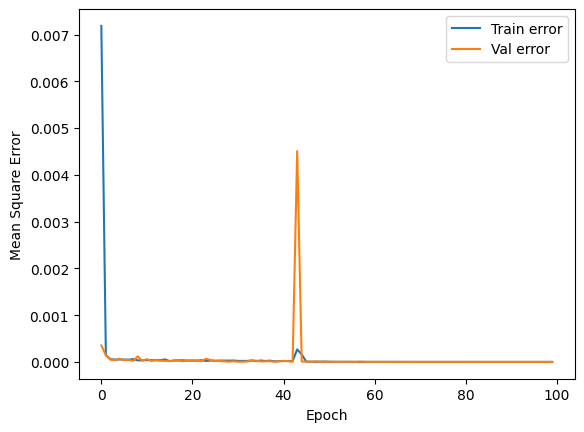

In [37]:
history_plot(history)

Con el conjunto de test podemos realizar, de forma similar a la validación, una comprobación de cómo se comporta el modelo ante nuevos datos, 
es decir, si es capaz de generalizar, o por el contrario no ha sido capaz de aprender o si se ha sobreajustado en exceso a los datos de entrenamiento.

Para ello, como por cada predicción podemos tener más de un ejemplar y este debe ser denormalizado para mostrar su rango original, es necesario
recorrer los _targets_ para realizar el proceso mencionado, además de obtener las predicciones de manera que puedan ser visualizadas posteriormente.

In [38]:
predictions = []
targets = []

for test_target in y_test:
    target = pd.DataFrame(data=test_target, columns=OUTPUT_COLS)
    target = denormalize(target)
    targets.append(target)

predictions = get_predictions(modelGRU, X_test)

188/188 [==============================] - 1s 3ms/step


Tras esto visualizamos los resultados junto con los valores reales en gráficas de dispersión por atributo y sensor.

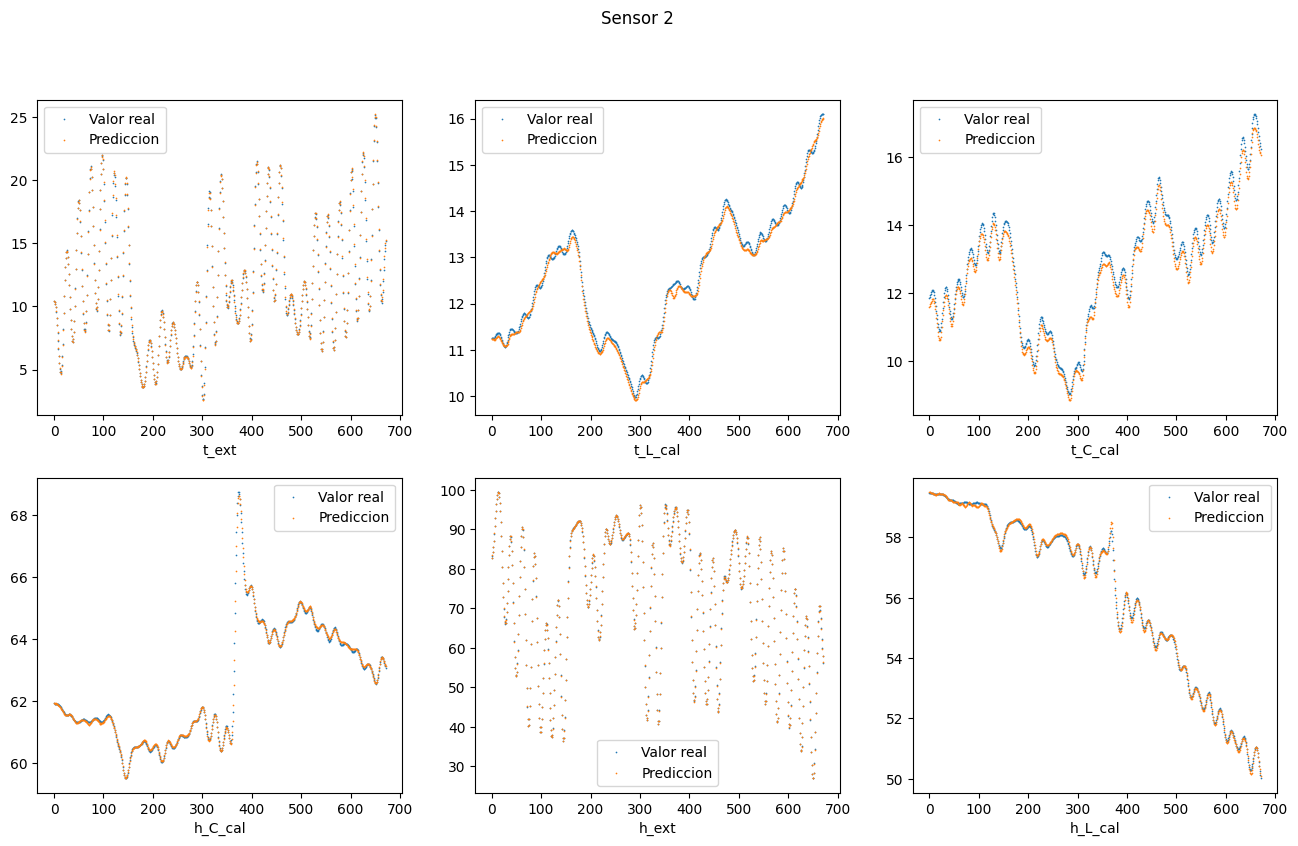

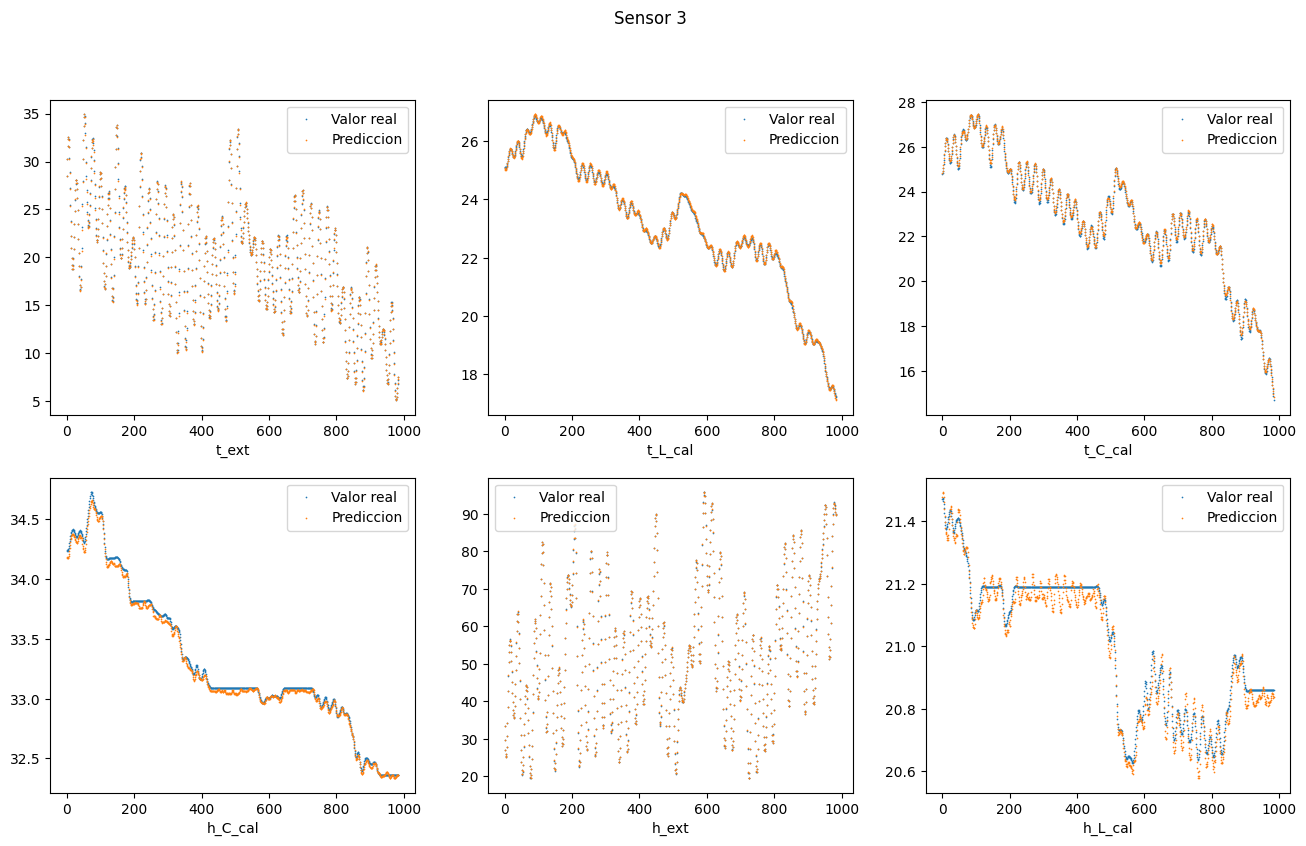

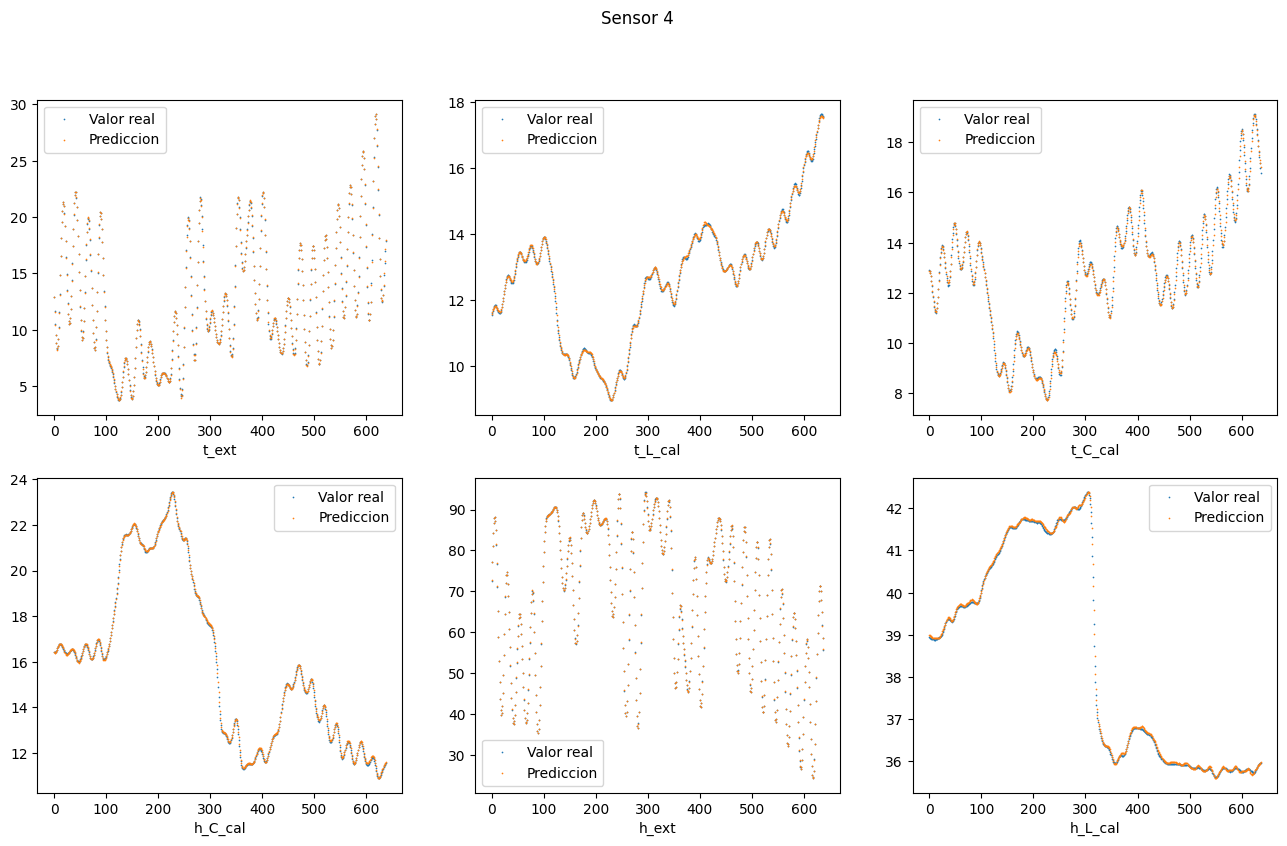

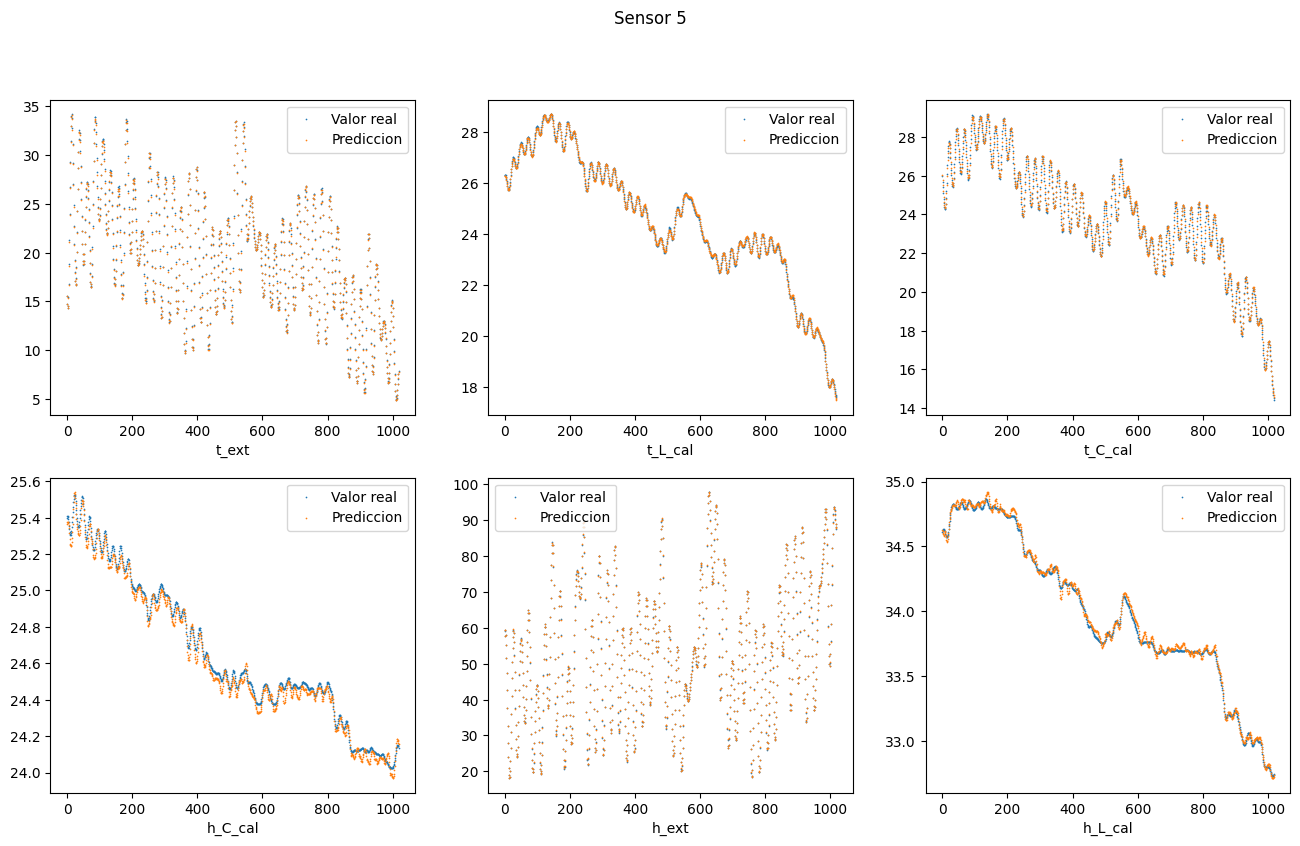

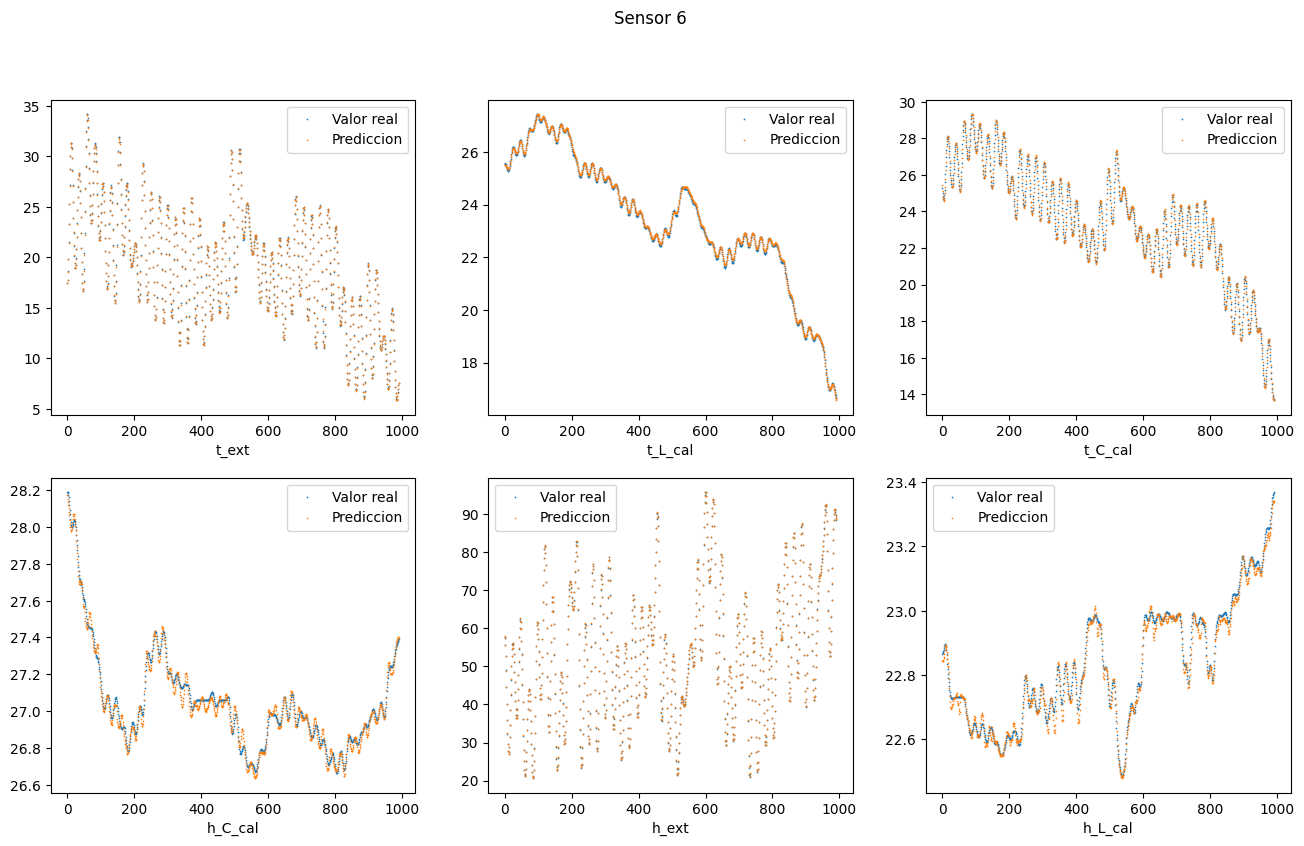

In [39]:
plot_results(targets, predictions, data_limits)

Graficamos de forma similar la distribución del error de las diferentes características, obteniendo, de esta forma, los errores máximos por
atributo.

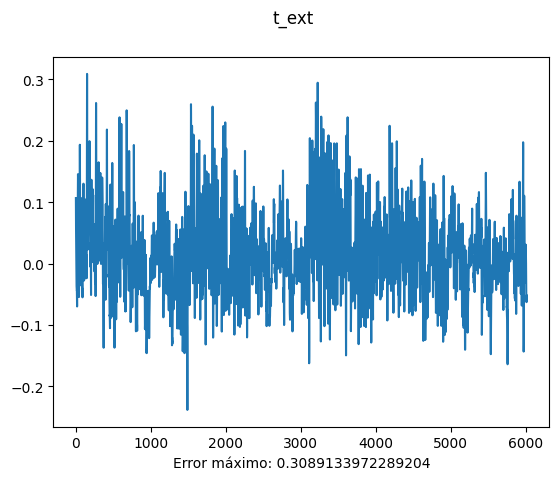

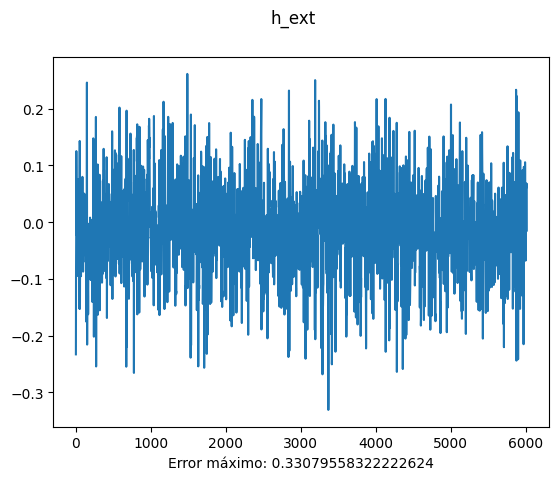

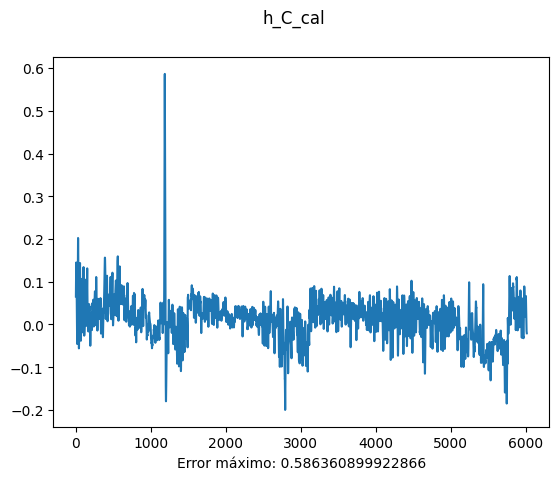

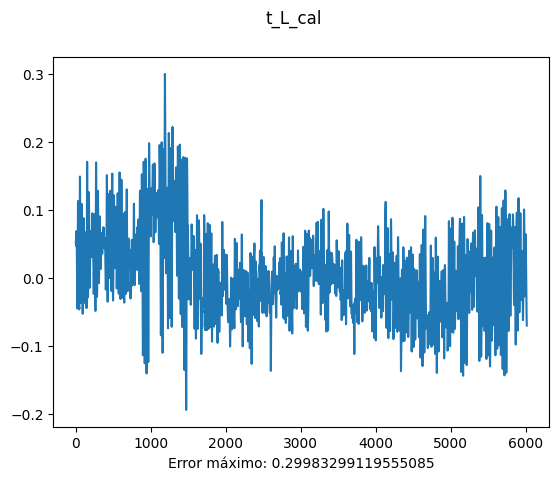

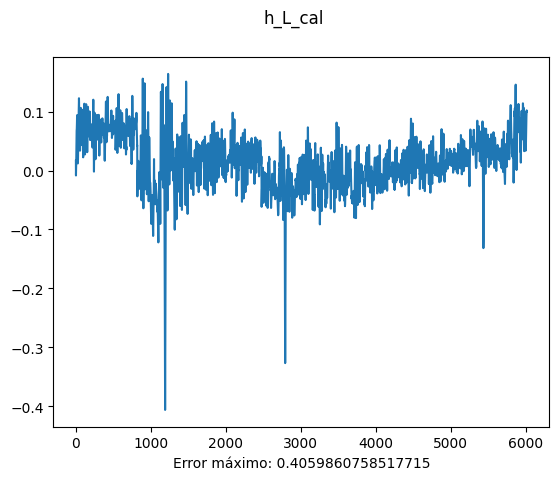

In [40]:
max_error(targets, predictions)

# LSTM

El modelado de _LSTM_ es idéntico al anterior (salvando el nombre de los _layers_ empleados), de forma que se siguen los mismos pasos desarrollados en _GRU_

In [41]:
inputs = layers.Input(shape=X_train.shape[1:])
modelLSTM = layers.LSTM(32, return_sequences=True)(inputs)
modelLSTM = layers.LSTM(32)(modelLSTM)
modelLSTM = layers.Dense(y.shape[1] * y.shape[2])(modelLSTM)
outputs = layers.Reshape((y.shape[1], y.shape[2]))(modelLSTM)

modelLSTM = kr.Model(inputs=inputs, outputs=outputs)
modelLSTM.compile(loss="mse", optimizer=get_optimizer())
modelLSTM.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 32)             5120      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
 reshape_4 (Reshape)         (None, 1, 6)              0         
                                                                 
Total params: 13,638
Trainable params: 13,638
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Entrenamiento de la RNA
history = modelLSTM.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[get_scheduler()], workers=32)

Epoch 1/100
177/177 [==============================] - 13s 35ms/step - loss: 0.0082 - val_loss: 4.8133e-04 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 4s 23ms/step - loss: 2.7537e-04 - val_loss: 2.2164e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 4s 25ms/step - loss: 1.3581e-04 - val_loss: 1.2998e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 4s 23ms/step - loss: 8.9192e-05 - val_loss: 7.4063e-05 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 4s 23ms/step - loss: 7.4203e-05 - val_loss: 7.2254e-05 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 4s 22ms/step - loss: 7.3084e-05 - val_loss: 5.4426e-05 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 4s 23ms/step - loss: 5.7815e-05 - val_loss: 9.1520e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 4s 22ms/step - loss: 6.3899e-05 - val_loss: 4.8429e-05 - lr: 0.0100
Epoch 9/100
177/177

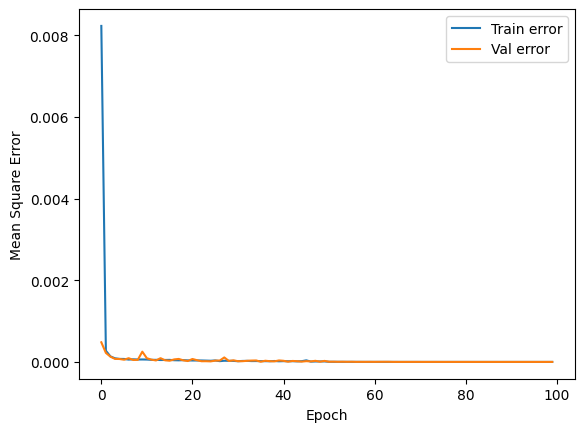

In [43]:
history_plot(history)

In [44]:
predictions = get_predictions(modelLSTM, X_test)

188/188 [==============================] - 2s 5ms/step


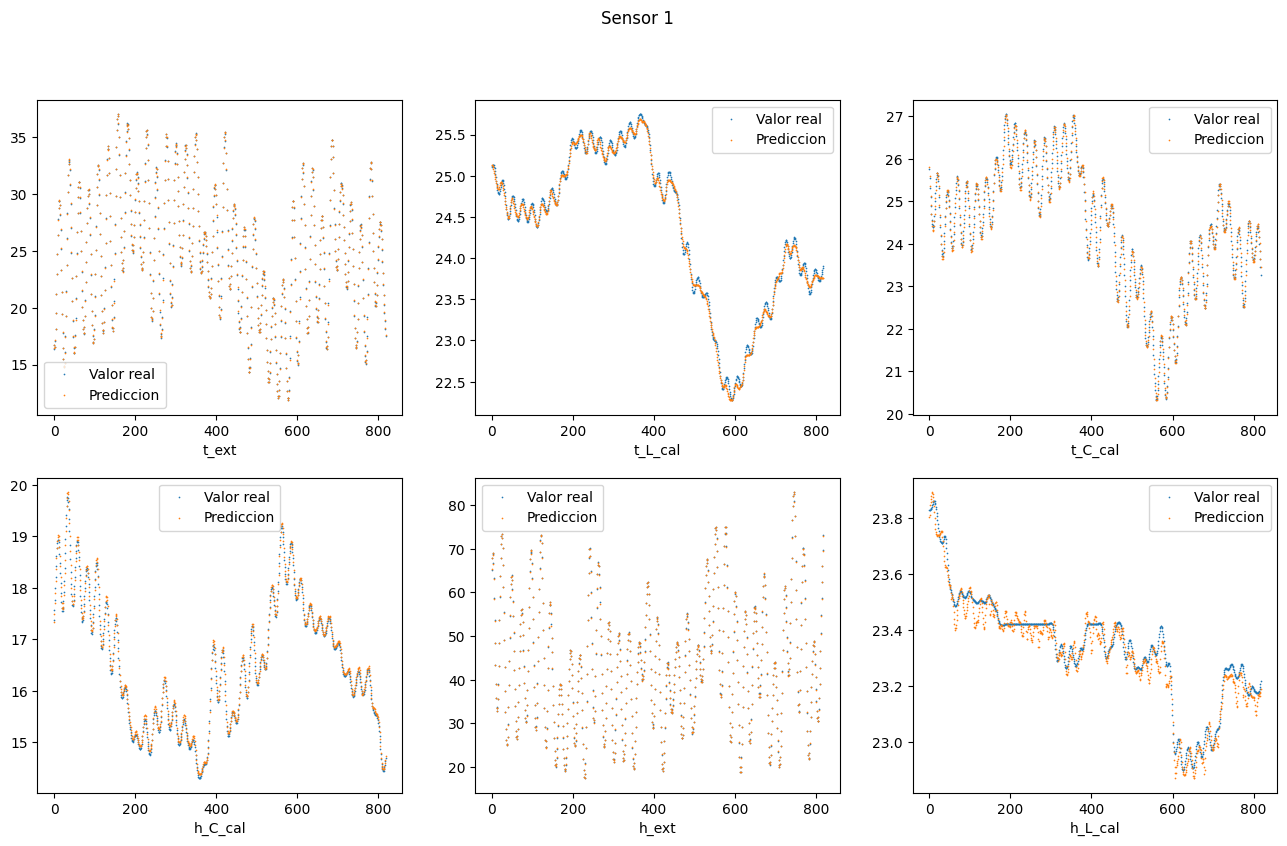

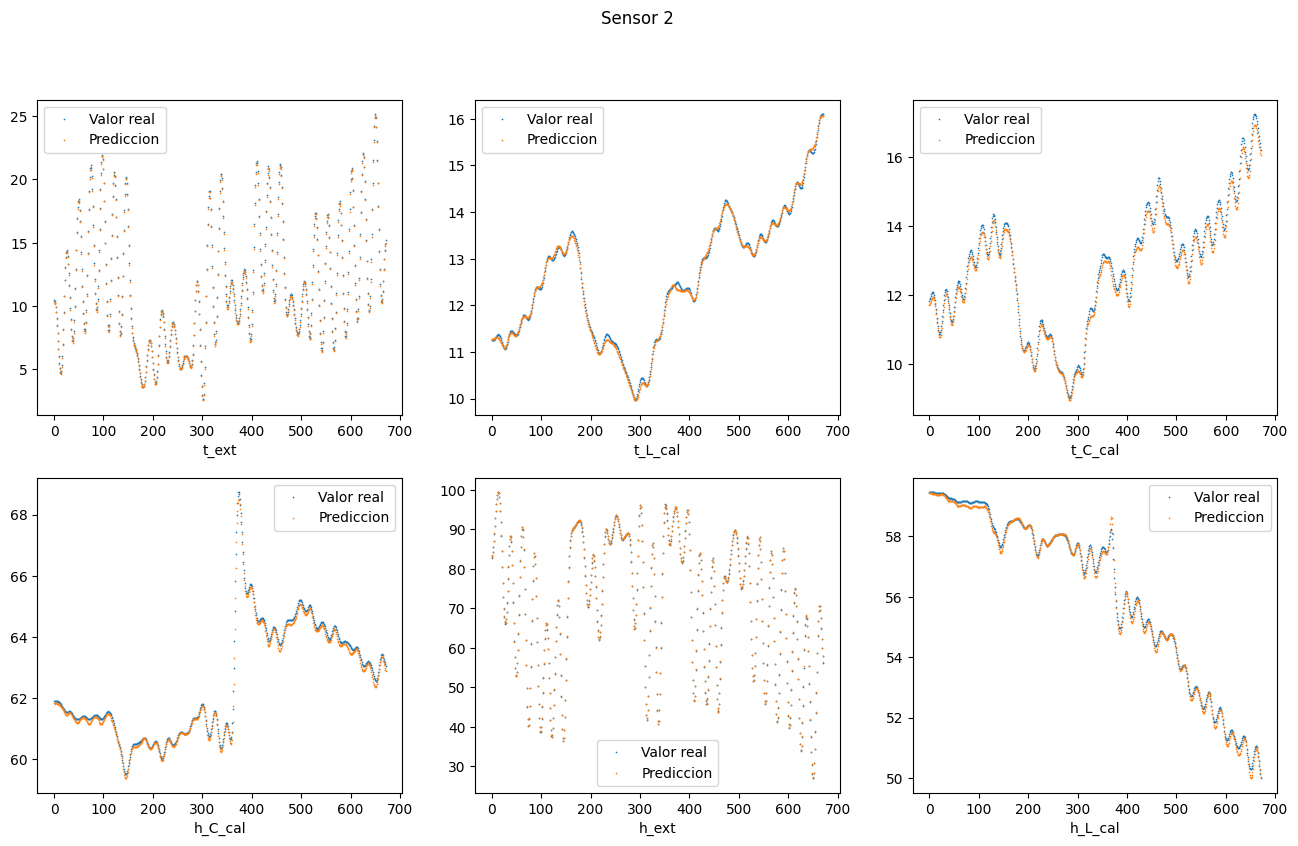

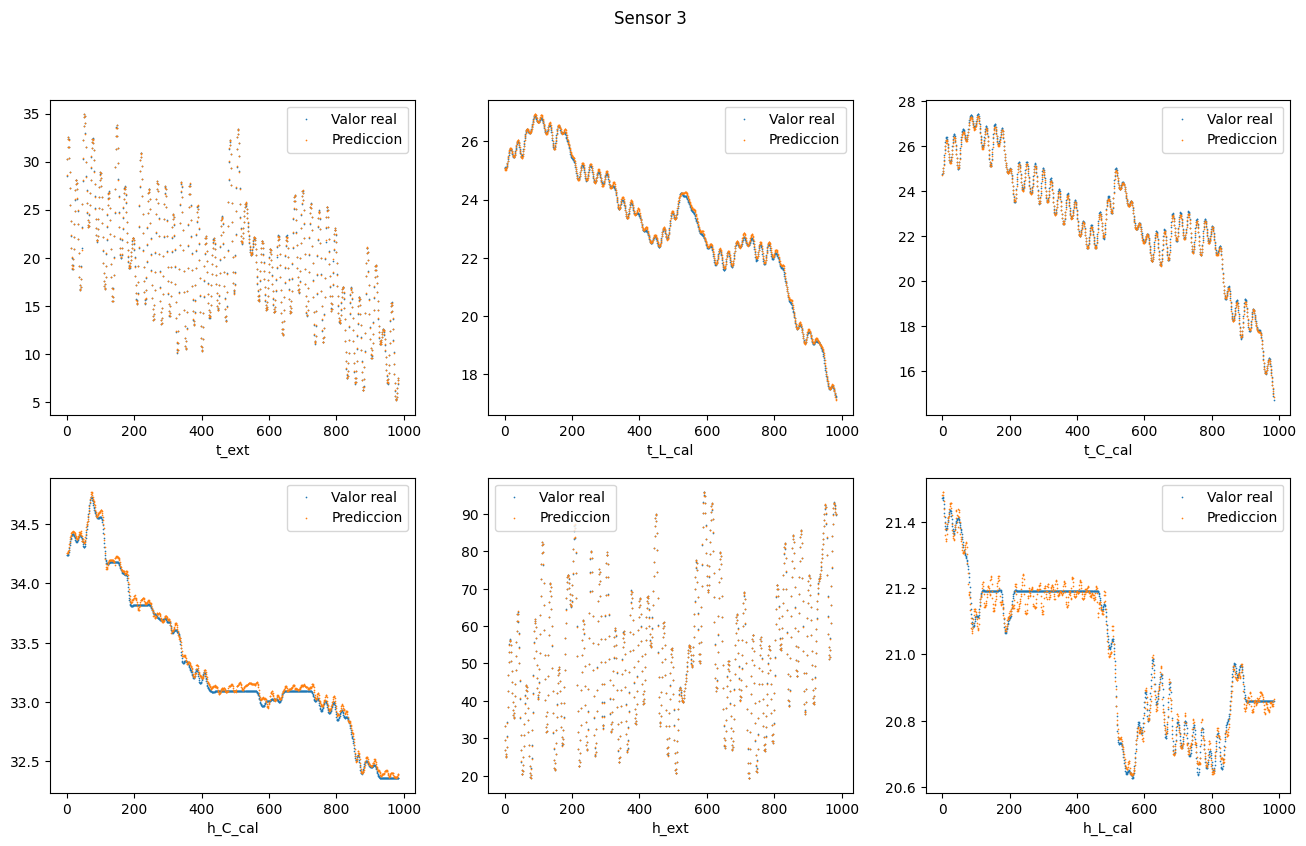

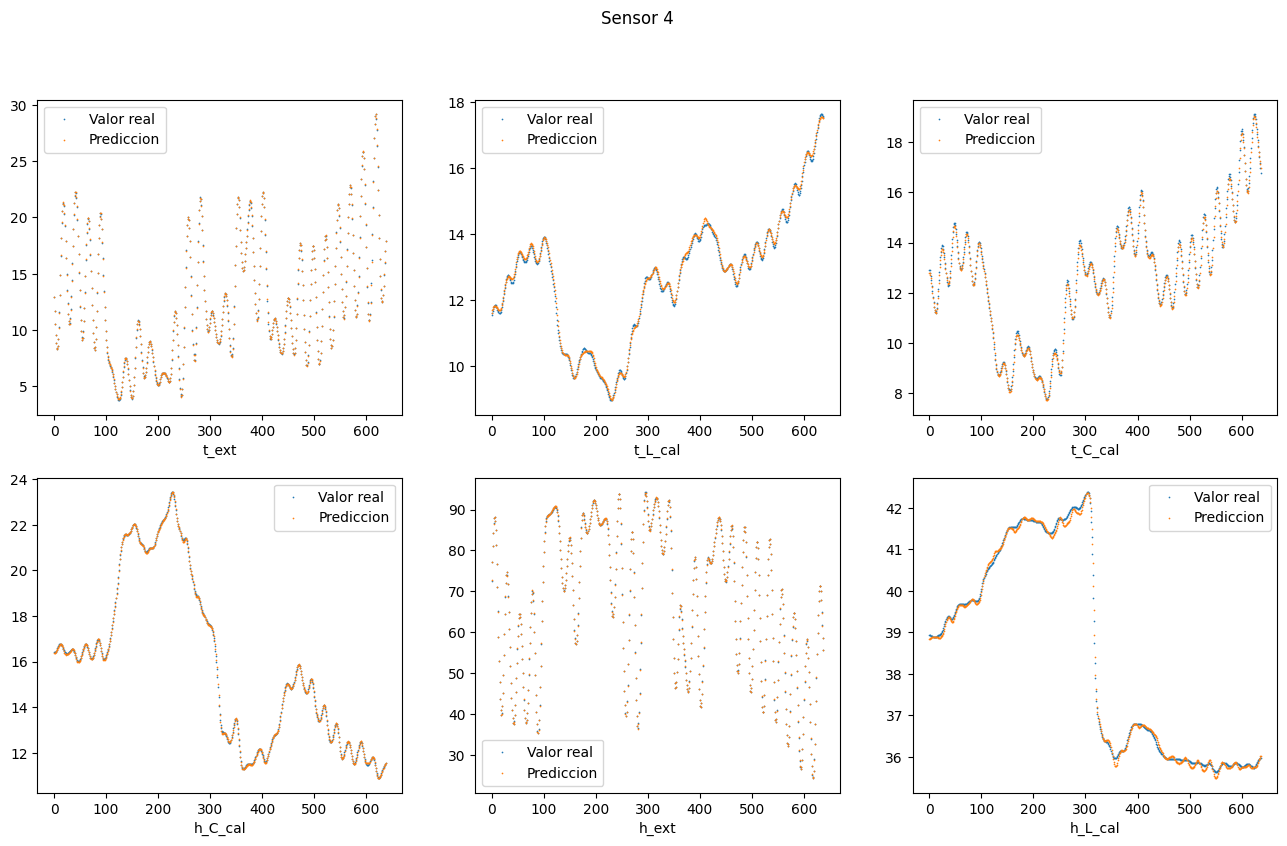

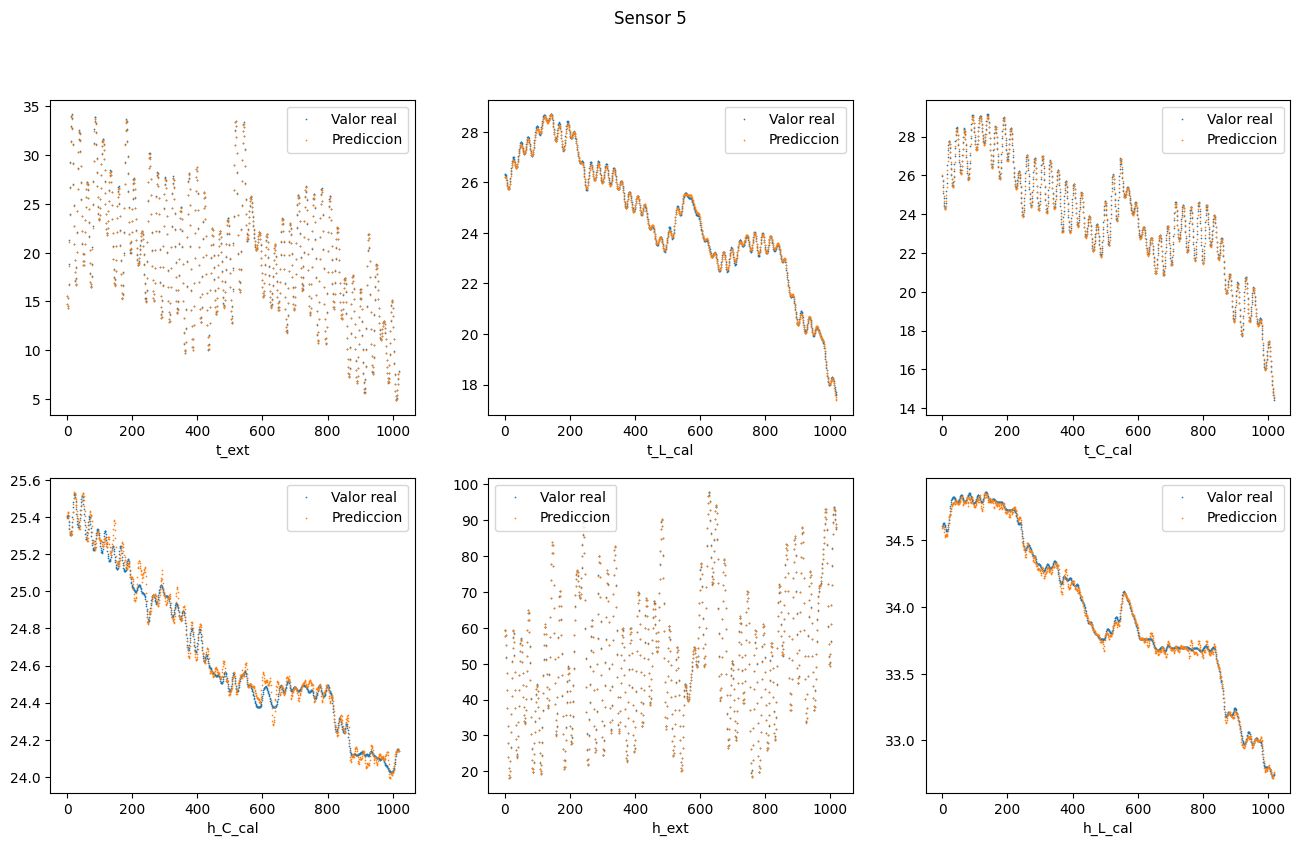

In [45]:
plot_results(targets, predictions, data_limits)

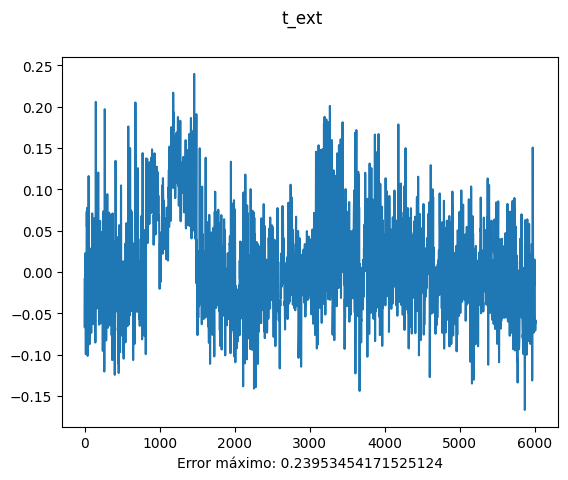

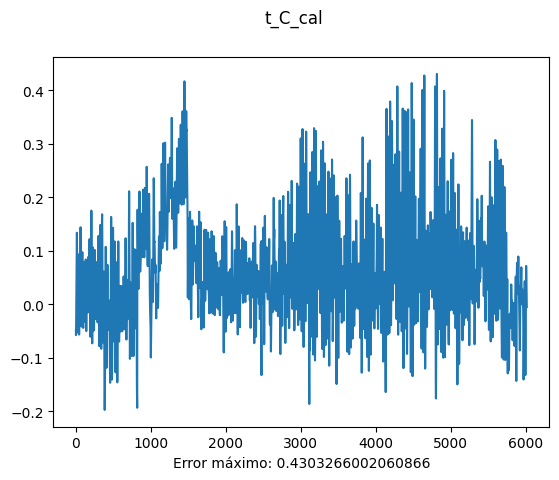

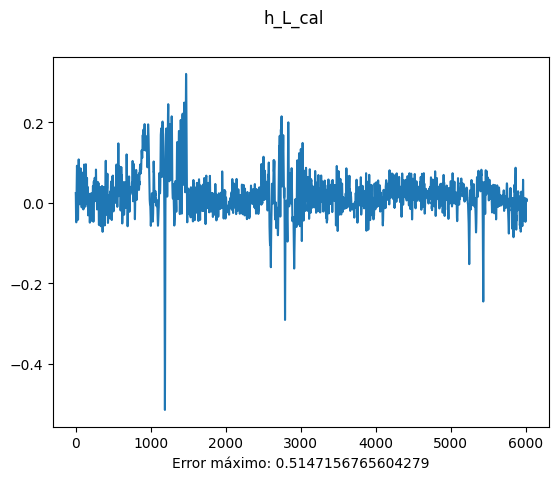

In [46]:
max_error(targets, predictions)

# MLP

_MLP_ no acepta secuencias de tiempo, puesto que son modelos "_feed-forward_", de forma que no tienen en cuenta los instantes anteriores de forma predeterminada.

Para que una secuencia temporal pueda ser tratada por este tipo de modelo neuronal, es necesario contar con una neurona de entrada por cada valor en la secuencia,
de manera que se debe modificar el tensor de entrada transformándolo en un vector.

De forma análoga, en la salida se obtendrá un vector, por lo que deberá ser modificado para obtener el tensor especificado.

In [47]:
# Modificamos los tensores de entrada transformandoles en vectores de entrada, para que pueden ser empleados por la MLP
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val_mlp = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

inputs = layers.Input(shape=X_train_mlp.shape[1:])
modelMLP = layers.Dense(32, activation="relu")(inputs)
modelMLP = layers.Dense(32, activation="relu")(modelMLP)
modelMLP = layers.Dense(y.shape[1] * y.shape[2])(modelMLP)
outputs = layers.Reshape((y.shape[1], y.shape[2]))(modelMLP)

modelMLP = kr.Model(inputs=inputs, outputs=outputs)
modelMLP.compile(loss="mse", optimizer=get_optimizer())
modelMLP.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_6 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense_7 (Dense)             (None, 32)                1376      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
 reshape_5 (Reshape)         (None, 1, 6)              0         
                                                                 
Total params: 2,630
Trainable params: 2,630
Non-trainable params: 0
_________________________________________________________________


En el entrenamiento se deben emplear los datos convertidos a vectores secuenciales, siendo esta peculiaridad la que se distingue de los otros modelos creados.

El resto de parámetros y operaciones se mantendrán y realizarán exactamente de la misma forma.

In [48]:
history = modelMLP.fit(x=X_train_mlp, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_mlp, y_val), callbacks=[get_scheduler()], workers=32)

Epoch 1/100
177/177 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 4.9384e-04 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 1s 3ms/step - loss: 2.7437e-04 - val_loss: 2.4591e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 1s 4ms/step - loss: 1.7528e-04 - val_loss: 2.2731e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 1s 3ms/step - loss: 1.4505e-04 - val_loss: 1.0269e-04 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 1s 3ms/step - loss: 1.1101e-04 - val_loss: 8.8118e-05 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 1s 3ms/step - loss: 9.2825e-05 - val_loss: 1.6765e-04 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 0s 3ms/step - loss: 9.6726e-05 - val_loss: 1.7361e-04 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 1s 3ms/step - loss: 9.0020e-05 - val_loss: 1.1902e-04 - lr: 0.0100
Epoch 9/100
177/177 [=======

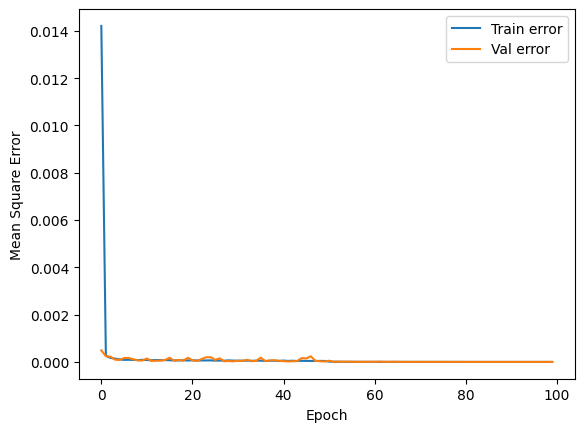

In [49]:
history_plot(history)

In [50]:
predictions = get_predictions(modelMLP, X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2])))

188/188 [==============================] - 0s 1ms/step


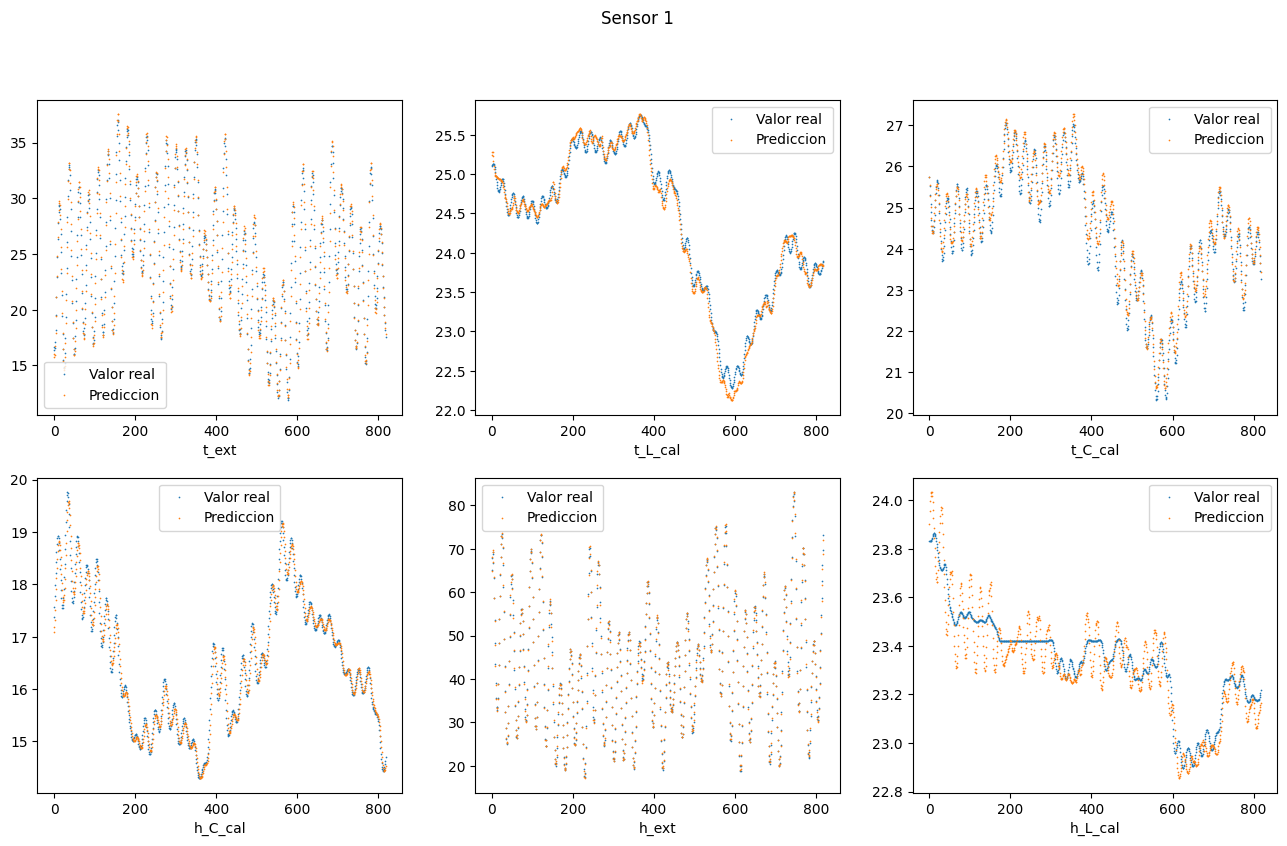

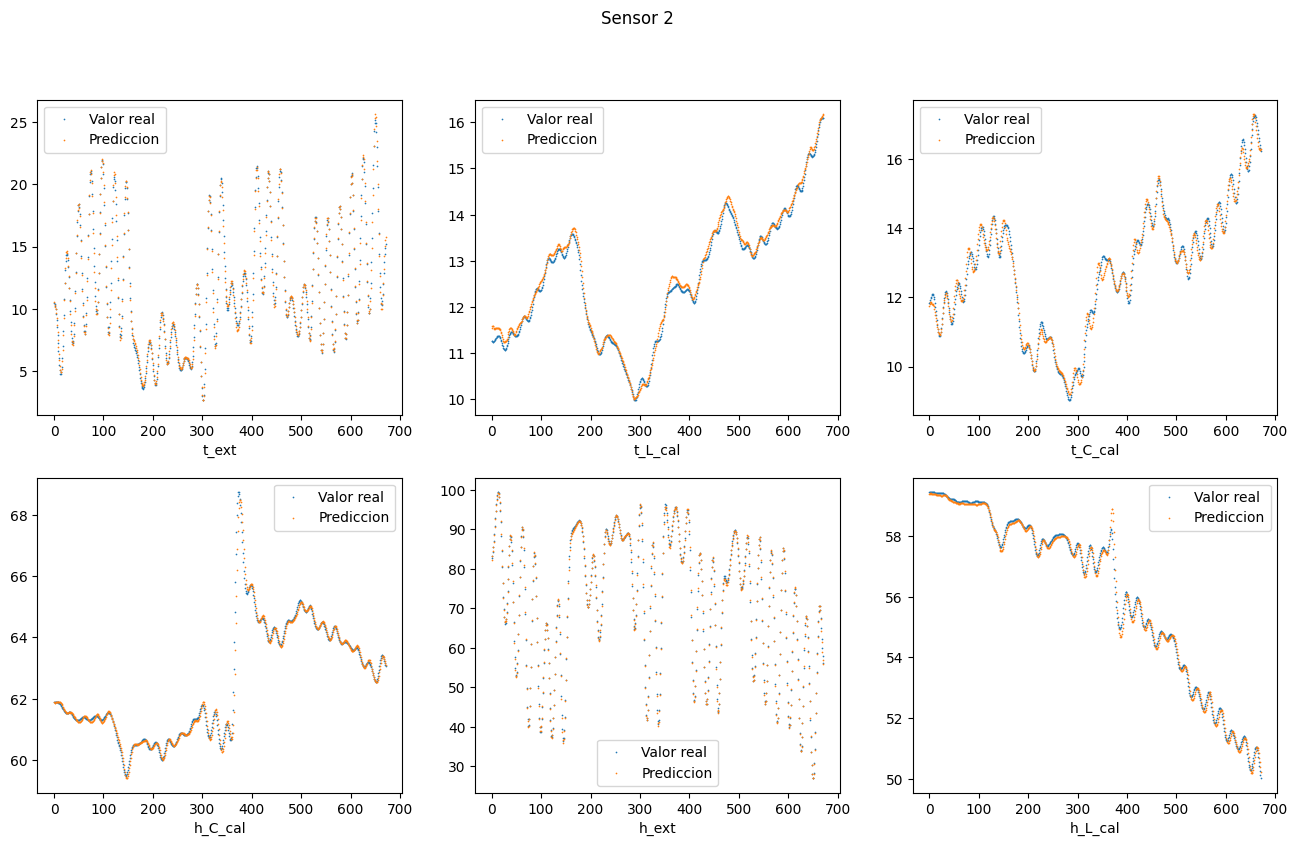

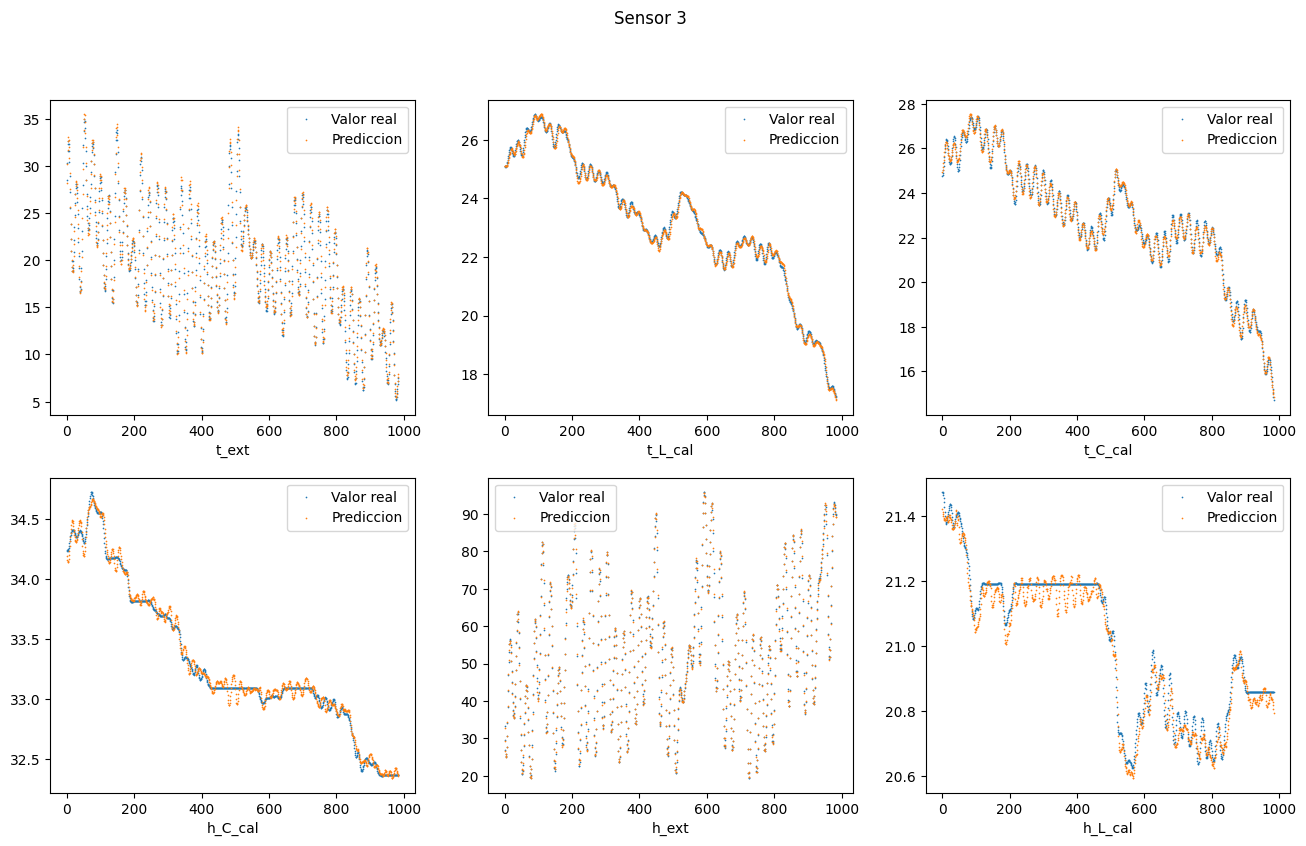

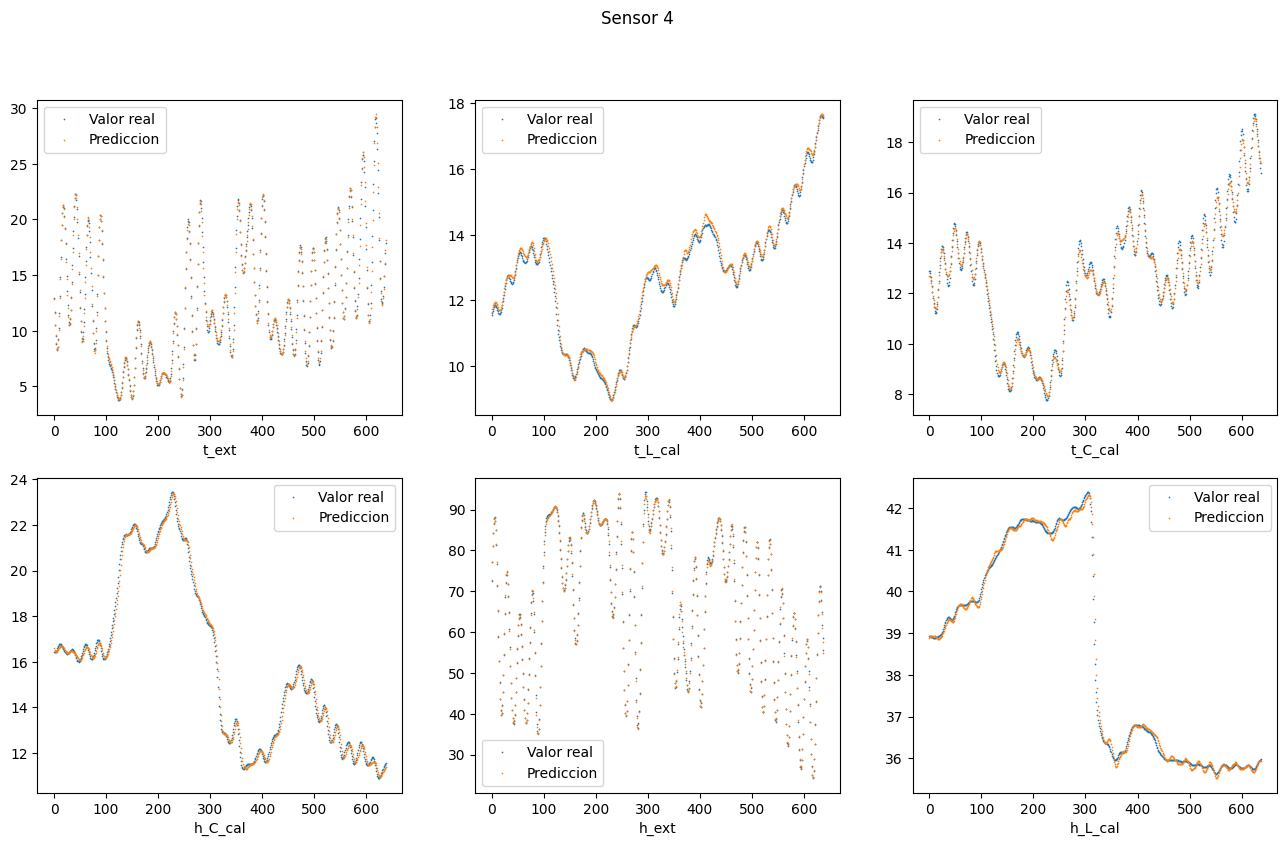

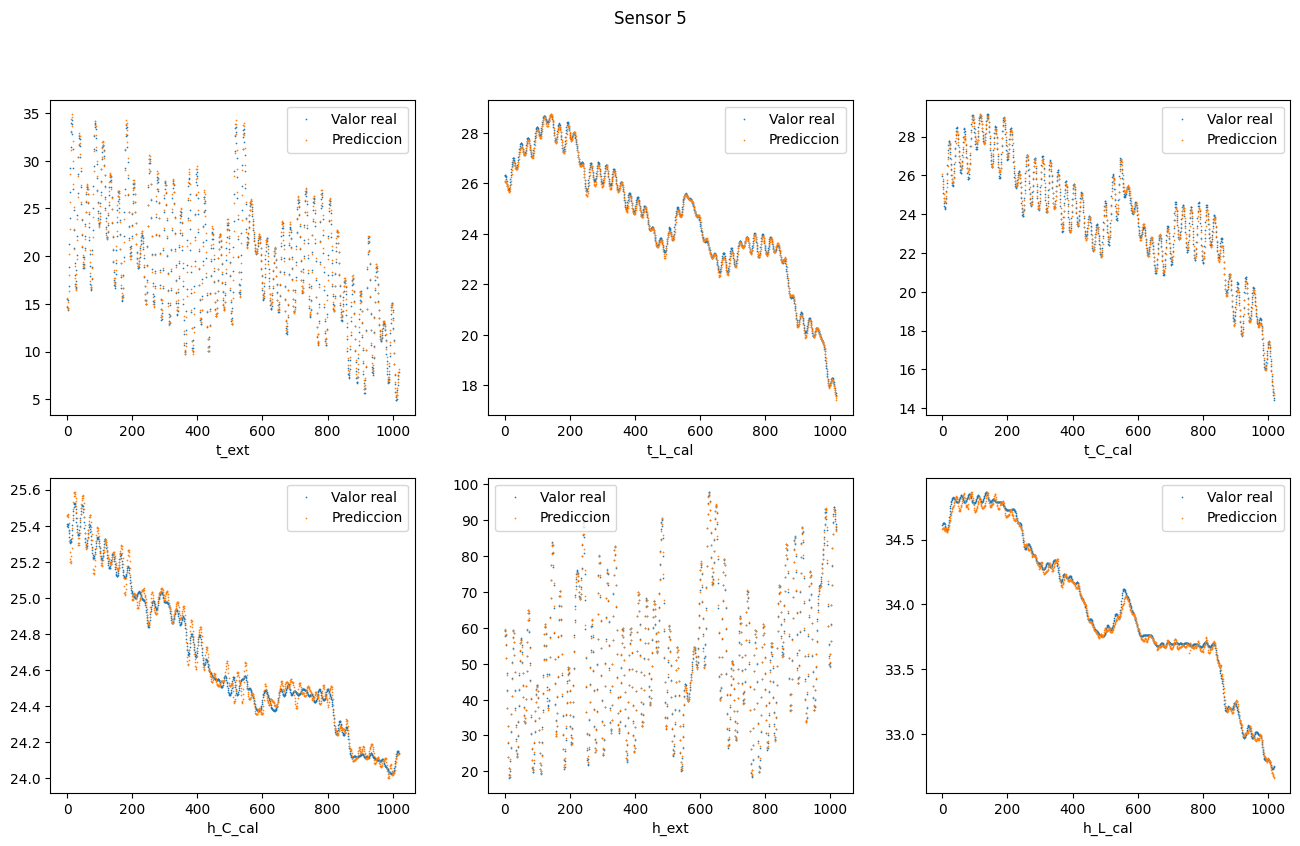

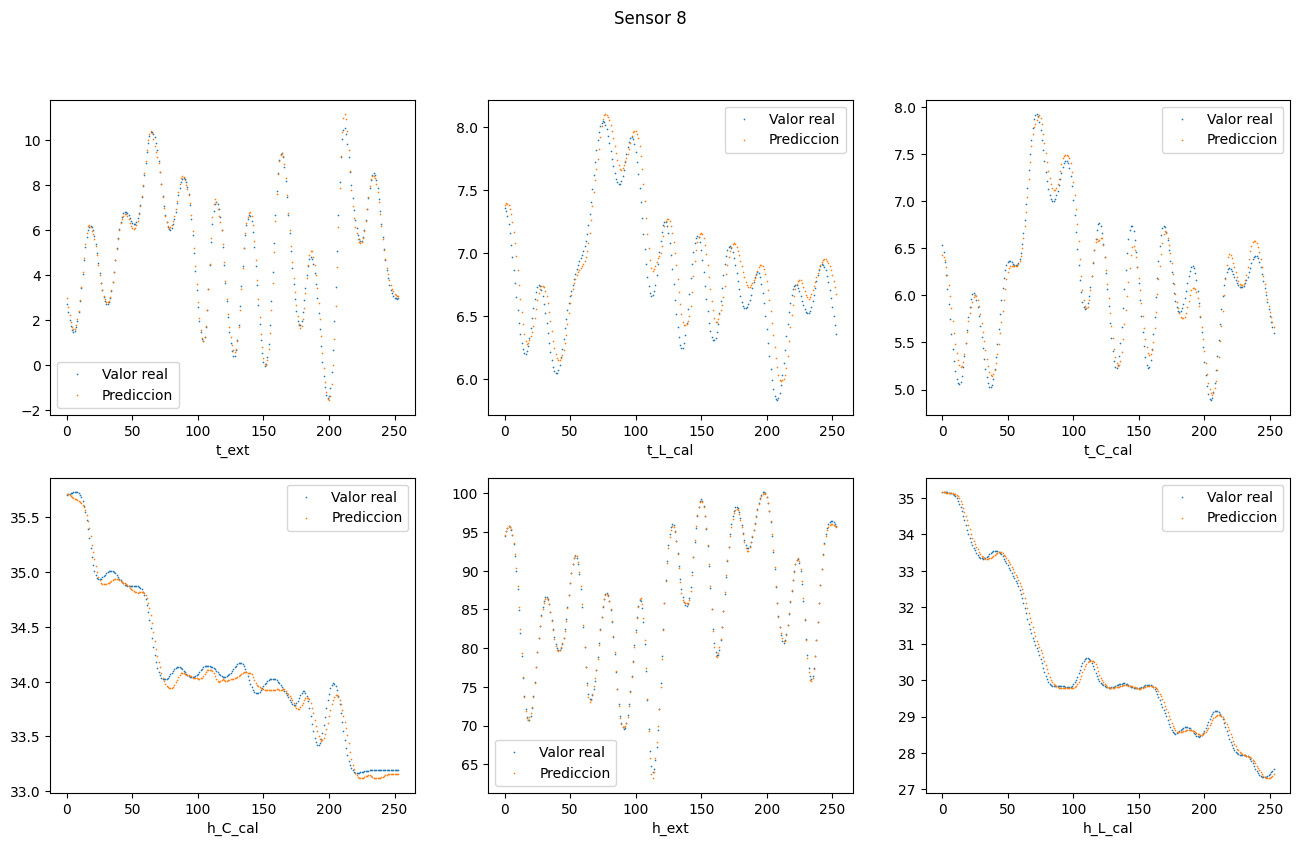

In [51]:
plot_results(targets, predictions, data_limits)

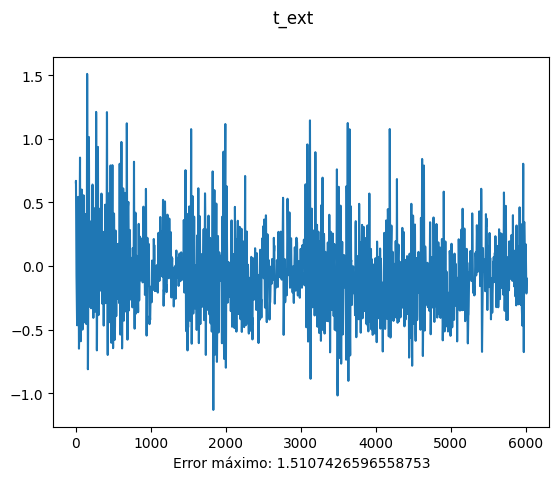

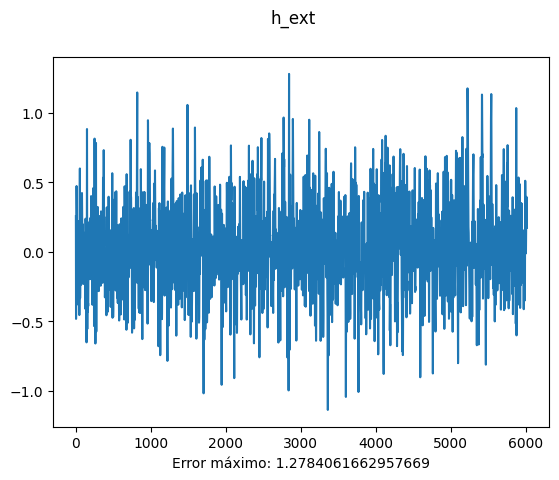

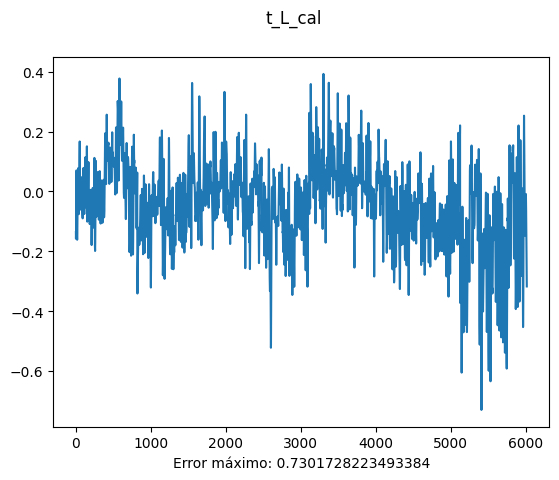

In [52]:
max_error(targets, predictions)

Finalmente se almacenan todos los modelos obtenidos en sus respectivos directorios, de forma que puedan ser empleados de forma posterior para un posible despliegue
en un producto software u otro tipo de desarrollo futuro.

In [53]:
modelGRU.save("./modelGRU", overwrite=True)
modelLSTM.save("./modelLSTM", overwrite=True)
modelMLP.save("./modelMLP", overwrite=True)

INFO:tensorflow:Assets written to: ./modelGRU\assets


INFO:tensorflow:Assets written to: ./modelGRU\assets


INFO:tensorflow:Assets written to: ./modelLSTM\assets


INFO:tensorflow:Assets written to: ./modelLSTM\assets


INFO:tensorflow:Assets written to: ./modelMLP\assets


INFO:tensorflow:Assets written to: ./modelMLP\assets
